# Clase 24

## Algoritmos vectorizados

Consideremos el caso en el que tenemos una función en la cual se condiciona el resultado según el valor del argumento

In [1]:
import numpy as np

def func_condicionada(n):
    '''
    Función que determina la raiz cuadrada de un número
    Args: n un número
    Res: Raiz del número n si n>=0
    '''
    if n<0:
        resultado = 0
    elif n>=0:
        resultado = np.sqrt(n)
        
    return resultado

print 'func_condicionada(-3) =', func_condicionada(-3)
print 'func_condicionada(5) =', func_condicionada(5)

func_condicionada(-3) = 0
func_condicionada(5) = 2.2360679775


Sin embargo las funciones de Python con tests `if` no tiene la capacidad de manejar arrays de numpy correctamente

In [5]:
x = np.array([-1,-2,-3,0,1,2,3],float)

func_condicionada(x)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

La operación n < 0 resulta en un array de booleanos en el cual un elemento es `True` si el elemento en el array `x` es menor que cero, y `False` en el otro caso.

In [6]:
x<0

array([ True,  True,  True, False, False, False, False], dtype=bool)

Sin embargo, el array no puede ser evaluado por la condición `if` como un booleano por lo cual se obtiene una excepción `ValueError`.

**Pregunta:** ¿Cómo podríamos extender la función `func_condicionada` arriba para que funciones para argumentos que sean arrays de Numpy?

Otra posible solución es usar la clase ´vectorize´ del paquete Numpy. Esta clase auntomáticamente vectoriza cualquier función de argumentos escalares de manera que funcione con arrays. Por ejemplo

In [8]:
np.vectorize?

In [12]:
func_condicionada_vec = np.vectorize(func_condicionada,otypes='d')     # vectorización de la función func_condicionada
                                                                      # que retorna valores float
print x
print func_condicionada_vec(x)

[-1. -2. -3.  0.  1.  2.  3.]
[ 0.          0.          0.          0.          1.          1.41421356
  1.73205081]


Desafortunadamente la velocidad de `func_condicionada_vec` es mucho más baja que una versión explícitamente vectorial.

En general no existen guías para vectorizar una función que no funciona con argumentos en forma de array porque la reescritura de esta depende de las funcionalidades presentes en la librería de numpy. Sin embargo, una función del tipo
```python
 def f(x):
        if condition:
            x = <expression1>
        else:
            x = <expression2>
        return x
```
se puede vectorizar como 
```python
def f_vectorized(x):
    x1 = <expression1>
    x2 = <expression2>
    return np.where(condition, x1, x2)
```
en donde la función `np.where` retorna un array del mismo tamaño que el de la condición y elemento `i`-esimo es igual a `x1[i]` si `condicion[i]` es verdadera, y `x2[i]` en otro caso.

In [13]:
np.where?

In [18]:
x = np.array([-1,-2,-3,0,1,2,3],float)
x1 = np.zeros_like(x)
x2 = np.sin(x)
print np.where(x<0,x1,x2)

[ 0.          0.          0.          0.          0.84147098  0.90929743
  0.14112001]


---
### Ejercicio
¿Cómo se podría escribir una versión vectorizada de la siguiente función?
```python
    def func_sin(x):
        if x < 0:
            return 0
        else:
            return sin(x)
```

Compare el tiempo de ejecución con la función vectorizada usando `np.vectorize`.

---

Algunas veces el cálculo no se puede hacer para todos los valores del array de entrada. Por ejemplo, Si `x<0` la función $\log x$ no está definida y por lo tanto `np.log(x)` producirá un error:

In [20]:
np.log(-3)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


nan

Una función escalar que evita este problema es la siguiente:

In [21]:
def logpos(x):
    if x <= 0:
        return 0.0
    else:
        return np.log(x)

In [22]:
logpos(-1)

0.0

Ahora, un simple `np.log(x)` cuando `x` es un array con elementos negativos no funcionará. Una forma de evitarlo es reemplazando las entradas ilegales en `x` por entradas legales, y luego calcular `np.log(x)`. Esto no es problematico porque las entradas reemplazadas no iban a formar parte del array resultante:

In [30]:
def logposv(x):
    x_pos = np.where(x > 0, x, 1) # subst. negative values by 1 r1 = log(x_pos)
    r1 = np.log(x_pos)
    r = np.where(x < 0, 0.0, r1)
    return r

In [31]:
logposv(x)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.69314718,  1.09861229])

---
### Ejercicio
Vectorize la función `func_condicionada` de manera que los valores problemáticos sean reemplazados por cero.

---

### Slicing

El slicing puede ser una técnica importante para vectorizar expresiones, especialmente en aplicaciones relacionadas con diferencias finitas, procesamiento de imágenes, o operaciones de compresión y suavisado. Consideremos el siguiente esquema de recursión (para $0<\beta\leq 1/2$)

$$
u_i^{l+1} = \beta u_{i-1}^l+(1-2\beta) u_{i}^l+\beta u_{i+1}^l,\quad i=1,\dots, n-1 \; \mathrm{y} \; l\geq 0
$$

---
**(Lectura opcional)**

que se obtiene a partir de la solución de la [ecuación de difusión](https://es.wikipedia.org/wiki/Ecuación_de_difusión) 
$$\frac{\partial u(x,t)}{\partial t}=\frac{\partial^2 u(x,t)}{\partial x^2}$$

usando [diferencias finitas](https://es.wikipedia.org/wiki/Diferencia_finita): el método de diferencias finitas reemplaza los cocientes diferenciales por cantidades finitas; la exactitud de la aproximación va a depender del tamaño de estas cantidades, *recuperando* la solución exacta cuando ellas son infinitamente pequeñas (para detalles muchísimo más específicos y técnicos vea [Introducción al Método de Diferencias Finitas y su Implementación Computacional](http://www.mmc.geofisica.unam.mx/femp/Ejemplitos/F_M/FDM/Introducción%20al%20Método%20de%20Diferencias%20Finitas%20y%20su%20Implementación%20Computacional.pdf)). 

En el esquema de recursión anterior la constante $\beta$ determina la relación entre la discretización del tiempo $\Delta t$ y la del espacio $\Delta x$ de manera que $\beta = \Delta t/ \Delta x^2$. Para asegurar la convergencia de la solución $0<\beta\leq 1/2$; la solución *exacta* se recupera cuando $\Delta t\rightarrow 0$ y $\Delta x\rightarrow 0$.

En esta aproximación el índice $l\geq 0$ cuenta niveles discretos de tiempo, de tal manera que el tiempo es $t_l = l\, \Delta t$. Similarmente el índice $i$ es el contador de puntos en el espacio con lo cual $x_i= i\, \Delta x$ para $i=0,\dots,n$ (donde $n$ es el número de divisiones en el espacio).

---

que computacionalmente se puede escribir representar como
```python
u[l+1,i] = beta*u[l,i-1]+(1-2*beta)*u[l,i]+beta*u[l,i+1]
```
donde el array `u` de dimensión $m\times n$ tiene elementos `u[l,i]` (para $l = 0,\dots, m$ y $i=1,\dots, n-1$) determinados por la recusión anterior y para el cual `u[:,0] = u[:,-1] = 1` y `u[0,1:-1] = 0`.

In [133]:
m = 100    # número de filas
n = 50     # número de columas

u = np.zeros((m,n),float)    # matriz llena de ceros

# Condiciones sobre la matriz
u[:,0] = 1
u[:,-1] = 1
u[0,1:-1] = 0

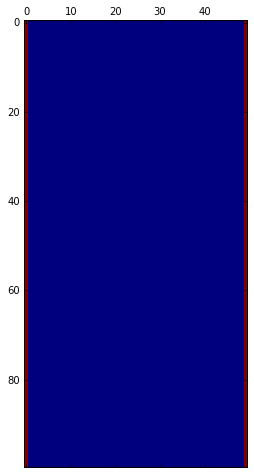

In [134]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.matshow(u)

---
### Ejercicio
Escriba el código necesario usando loops de python para aplicar la recursión definida antes sobre el array `u` dado un coeficiente `beta = 0.5`. Utilice el comando `plt.matshow(u)` para ver el resultado.

---

Una versión vectorizada del problema anterior
```python
u[l+1,i] = beta*u[l,i-1]+(1-2*beta)*u[l,i]+beta*u[l,i-1]
```
consiste en adicionar tres arrays de una dimension: `u[j,0:n-2]`, `u[j,1:n-1]`, `u[j,2:n+1]` para un `j` determinado, con los coeficientes escalares correspondientes; es decir, el doble loop de python puede ser reemplazado por uno simple

In [141]:
beta = 0.5

for j in xrange(0,m-1):
    u[j+1,1:n-1] = beta*u[j,0:n-2]+(1-2*beta)*u[j,1:n-1]+beta*u[j,2:n+1]

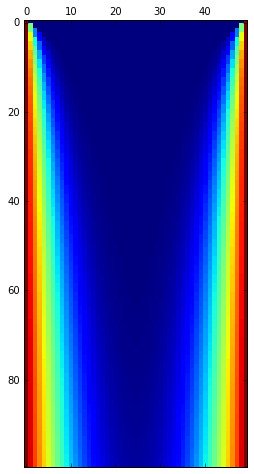

In [142]:
plt.matshow(u)

---
### Ejercicio

**1.** *Vectorizando una función constante*. La función
```python
def initial_condition(x):
    return 3.0
```
no funciona de manera correcta cuando `x` es un array de Numpy. En ese caso la función debería retornar un array del mismo tamaño que `x` y con todas sus entradas iguales a `3.0`. Haga las modificaciones necesarias para que la función dé el reultado esperado tanto para `x` escalares como arrays.

**2.** *Vectorizando una integración numérica*. La integral de una función $f(x)$ desde $x=a$ hasta $x=b$ puede ser calculada numericamente por la regla del trapezoide:
$$
\int_a^b f(x)\, \mathrm{d}x \approx \frac{h}{2} f(a) + \frac{h}{2} f(b) + h \sum_{i_1}^{n-1} f(a+ih) \quad h=\frac{b-a}{n}.
$$
Implemente esta aproximación en python usando `loops`. Este funcionará más lento que una versión vectorizada. Haga los ajustes necesarios para obtener una versión vectorizada y compare el tiempo de ejecución con la versión usando `loops`. Para lo anterior use las funciones
$$
f(x)=1+2x\quad \mathrm{y}\quad f(x)=\sin(x)
$$
para $a=0$ y $b=\pi/2$. Compare la precisión del resultado con la obtenida usando el método del rectángulo.

**3.** *Vectorizando una función con una condición if*. Considere la función 
$$
f(x) = \frac{n}{1+n}\left\{
  \begin{array}{lr}
    0.5^{1+\frac{1}{n}}-(0.5-x)^{1+\frac{1}{n}}, & 0 \leq x \leq 0.5\\
    0.5^{1+\frac{1}{n}}-(x-0.5)^{1+\frac{1}{n}}, & 0.5 < x \leq 1
  \end{array}
\right.
$$
en donde $n$ es un número real tal que $0<n\leq 1$. (Esta ecuación describe la velociadad de un fluído en un canal cuando es sometido a presión.) Haga una función vectorizada para evaluar $f(x)$ para un conjunto $x$ de $m$ puntos igualmente espaciados entre 0 y 1 (no debe aparecer nungún loop sobre los valores de $x$), de tal maera que
```python
r = f(x)
```
donde `r` es un array con los resultados de aplicar `f(x)` sobre un array `x`.

Utilice luego la siguiente secuencia de comandos para visualizar sus resultados:
```python
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x,r)
```

---